### Training MNIST with Zalando's fashion data set
![zalando box](zalando_box.jpg)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import os

from matplotlib import pyplot as plt

import tensorflow as tf

import dataset

from helpers.gpu_utils import validate_batch_size_for_multi_gpu
from helpers.softmax_cross_entropy_trainer import create_model_fn

In [2]:
from models.conv2_dense2_dropout import Model

In [3]:
from models.dense3 import Model

In [15]:
FLAGS=lambda: None
FLAGS.multi_gpu=False
FLAGS.model_dir='/tmp/mnist_model'
FLAGS.data_dir='data/digits'
#FLAGS.data_dir='data/fashion'
FLAGS.batch_size=128
FLAGS.train_epochs=2

In [16]:
!rm -rf /tmp/mnist_model

Let's peek into the Zalando box!

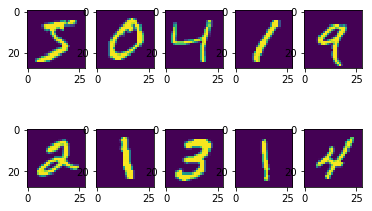

In [17]:
sess = tf.InteractiveSession()
test_set = dataset.training_dataset(FLAGS.data_dir)
samples = test_set.batch(4000).make_one_shot_iterator().get_next()
samples = sess.run(samples)
f, arr = plt.subplots(2,5)
for row in (0, 1):
    for col in range(5):
        i = 5 * row + col
        img = samples[0][i].reshape([28,28])
        arr[row, col].imshow(img)

above you see some examples of the 10 classes of fashion 

| Label | Description |
--------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle Boot  |

### Dimension reduction with Tensorboard
Before we start the training, let's have a look at the similarity between image vectors of particular classes

In [12]:
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.tensorboard.plugins import projector

LOG_DIR = '/tmp/logs'

images = tf.Variable(samples[0], name='images')
    
metadata = os.path.join(LOG_DIR, 'metadata.tsv')

with open(metadata, 'w') as metadata_file:
    for row in samples[1]:
        metadata_file.write('%d\n' % row)

with tf.Session() as sess:
    saver = tf.train.Saver([images])

    sess.run(images.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'images.ckpt'))

    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = images.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = metadata
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)

In [14]:
!tensorboard --logdir=/tmp/logs

TensorBoard 1.6.0 at http://wolfgangs-mac-pro.home:6006 (Press CTRL+C to quit)
^C


In [16]:
model_function = create_model_fn(lambda params: Model(params), tf.train.AdamOptimizer())

In [17]:
if FLAGS.multi_gpu:
    validate_batch_size_for_multi_gpu(FLAGS.batch_size)

    # There are two steps required if using multi-GPU: (1) wrap the model_fn,
    # and (2) wrap the optimizer. The first happens here, and (2) happens
    # in the model_fn itself when the optimizer is defined.
    model_function = tf.contrib.estimator.replicate_model_fn(
        model_function, loss_reduction=tf.losses.Reduction.MEAN)

data_format = ('channels_first' if tf.test.is_built_with_cuda() else 'channels_last')

In [18]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=model_function,
    model_dir=FLAGS.model_dir,
    params={
        'data_format': data_format,
        'multi_gpu': FLAGS.multi_gpu
    })

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/mnist_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x117ba1160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


##### ```input_fn``` functions are a factories for ```DataSet```s

In [19]:
def train_input_fn():
    ds = dataset.training_dataset(FLAGS.data_dir)
    ds = ds.cache().shuffle(buffer_size=50000).\
        batch(FLAGS.batch_size).\
        repeat(FLAGS.train_epochs)
    return ds

In [20]:
def eval_input_fn():
    return dataset.test_dataset(FLAGS.data_dir).batch(
        FLAGS.batch_size).make_one_shot_iterator().get_next()

In [21]:
tensors_to_log = {'train_accuracy': 'train_accuracy'}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=100)

In [22]:
mnist_classifier.train(input_fn=train_input_fn, hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mnist_model/model.ckpt.
INFO:tensorflow:train_accuracy = 0.1171875
INFO:tensorflow:loss = 2.4075556, step = 1
INFO:tensorflow:global_step/sec: 71.8177
INFO:tensorflow:train_accuracy = 0.453125 (1.393 sec)
INFO:tensorflow:loss = 0.5541303, step = 101 (1.393 sec)
INFO:tensorflow:global_step/sec: 177.999
INFO:tensorflow:train_accuracy = 0.5963542 (0.562 sec)
INFO:tensorflow:loss = 0.41253126, step = 201 (0.562 sec)
INFO:tensorflow:global_step/sec: 179.082
INFO:tensorflow:train_accuracy = 0.6542969 (0.558 sec)
INFO:tensorflow:loss = 0.45018226, step = 301 (0.558 sec)
INFO:tensorflow:global_step/sec: 167.426
INFO:tensorflow:train_accuracy = 0.7015625 (0.597 sec)
INFO:tensorflow:loss = 0.30093133, step = 401 

In [23]:
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print('Evaluation results:\n\t%s' % eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-24-21:46:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_model/model.ckpt-938
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-24-21:46:28
INFO:tensorflow:Saving dict for global step 938: accuracy = 0.8691, global_step = 938, loss = 0.36499518
Evaluation results:
	{'accuracy': 0.8691, 'loss': 0.36499518, 'global_step': 938}
